Contributors: Rohit Singh Rathaur, Girish L.

Copyright 2021 [Rohit Singh Rathaur, BIT Mesra and Girish L., CIT GUBBI, Karnataka]

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

We mounted the drive to access the data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We are importing the libraries:
- TensorFlow: to process and train the model
- Matplotlib: to plot the training anf loss curves
- Pandas: used for data analysis and it allows us to import data from various formats
- Numpy: For array computing

In [ ]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

We are reading the CSV file using `read_csv` function and storing it in a DataFrame named `df_Ellis`

In [ ]:
df_Ellis  = pd.read_csv("/content/drive/MyDrive/Failure/lstm/Ellis_FinalTwoConditionwithOR.csv")
df_Ellis

,Timestamp,ellis-cpu.system_perc,ellis-cpu.wait_perc,ellis-load.avg_1_min,ellis-mem.free_mb,ellis-net.in_bytes_sec,ellis-net.out_packets_sec,Label
0,14-09-2016 0:00,0.5,12.9,1.730,3949,5413.200,62.067,1
1,14-09-2016 0:00,0.4,10.3,1.790,3950,5201.667,59.567,1
2,14-09-2016 0:01,0.4,11.8,1.520,3950,5370.733,61.200,1
3,14-09-2016 0:01,0.4,12.9,1.430,3949,5292.467,60.400,1
4,14-09-2016 0:02,0.5,12.1,1.440,3950,5318.167,61.700,1
...,...,...,...,...,...,...,...,...
176995,13-12-2016 21:20,0.4,0.3,0.030,3484,230.967,2.167,0
176996,13-12-2016 21:20,0.2,0.3,0.018,3484,218.433,0.767,0
176997,13-12-2016 21:21,0.6,0.3,0.010,3483,160.967,1.867,0
176998,13-12-2016 21:21,0.6,0.3,0.007,3484,188.367,2.100,0


`plot()` function is used to draw points

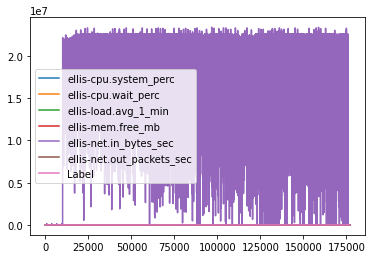

In [ ]:
df_Ellis.plot()

Using multivariate features:
- Storing only the multivariate features in a dataframe named `features_3`
- Extracting the Timestamp column from `df_Ellis` dataframe
- and combining it with the dataframe `features`

In [ ]:
## ## using multivariate feature 

features_3 = ['ellis-cpu.system_perc', 'ellis-cpu.wait_perc', 'ellis-load.avg_1_min', 'ellis-mem.free_mb', 'ellis-net.in_bytes_sec', 'ellis-net.out_packets_sec', 'Label']

features = df_Ellis[features_3]
features.index = df_Ellis['Timestamp']
features.head()

,ellis-cpu.system_perc,ellis-cpu.wait_perc,ellis-load.avg_1_min,ellis-mem.free_mb,ellis-net.in_bytes_sec,ellis-net.out_packets_sec,Label
Timestamp,,,,,,,
14-09-2016 0:00,0.5,12.9,1.73,3949,5413.200,62.067,1
14-09-2016 0:00,0.4,10.3,1.79,3950,5201.667,59.567,1
14-09-2016 0:01,0.4,11.8,1.52,3950,5370.733,61.200,1
14-09-2016 0:01,0.4,12.9,1.43,3949,5292.467,60.400,1
14-09-2016 0:02,0.5,12.1,1.44,3950,5318.167,61.700,1


Plotted features

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb836b5d10>,
      dtype=object)

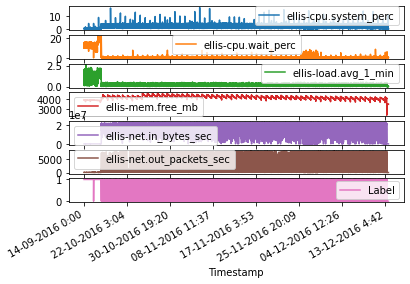

In [ ]:
features.plot(subplots=True)

In [ ]:
features = features.values

In [ ]:
### standardize data
train_split = 141600
tf.random.set_seed(13)

### standardize data
features_mean = features[:train_split].mean()
features_std = features[:train_split].std()
features  = (features - features_mean)/ features_std

print(type(features))
print(features.shape)


<class 'numpy.ndarray'>
(177000, 7)


In [ ]:
### create mutlivariate data

def mutlivariate_data(features , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(features)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(features[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

We spliited the multivariate data in tarining and validation and printed the shape of that data.

In [ ]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(features , features[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(features , features[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)
print(x_val_ss.shape , y_val_ss.shape)

(140880, 120, 7) (140880,)
(34608, 120, 7) (34608,)


The `tf.data.Dataset` API supports writing descriptive and efficient input pipelines. Dataset usage following a common pattern:
- Creating a source dataset from our input data.
- Applied dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.
Note: Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.
Once we have a dataset, we can apply transformations to prepare the data for our model:

In [ ]:
## tensorflow dataset
batch_size = 256
buffer_size = 10000

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset shapes: ((None, 120, 7), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 7), (None,)), types: (tf.float64, tf.float64)>


We used a custom loss function to evaluate the model:

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

We are building a single step LSTM model for training data with dropout 0.3 and we used ADAM optimizers.

Epoch 1/20
50/50 [==============================] - 9s 136ms/step - loss: 0.0899 - rmse: 0.1852 - val_loss: 0.0184 - val_rmse: 0.0281
Epoch 2/20
50/50 [==============================] - 6s 126ms/step - loss: 0.0069 - rmse: 0.0119 - val_loss: 0.0130 - val_rmse: 0.0175
Epoch 3/20
50/50 [==============================] - 6s 125ms/step - loss: 0.0047 - rmse: 0.0078 - val_loss: 0.0058 - val_rmse: 0.0093
Epoch 4/20
50/50 [==============================] - 6s 124ms/step - loss: 0.0034 - rmse: 0.0046 - val_loss: 0.0103 - val_rmse: 0.0105
Epoch 5/20
50/50 [==============================] - 6s 127ms/step - loss: 0.0083 - rmse: 0.0106 - val_loss: 0.0089 - val_rmse: 0.0089
Epoch 6/20
50/50 [==============================] - 6s 126ms/step - loss: 0.0057 - rmse: 0.0070 - val_loss: 0.0018 - val_rmse: 0.0021
Epoch 7/20
50/50 [==============================] - 6s 125ms/step - loss: 0.0039 - rmse: 0.0044 - val_loss: 0.0052 - val_rmse: 0.0054
Epoch 8/20
50/50 [==============================] - 6s 124ms/s

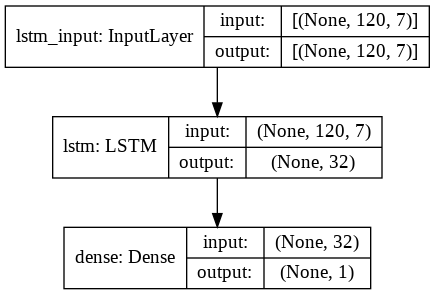

In [ ]:
from keras.layers import Activation, Dense, Dropout
from keras.utils.vis_utils import plot_model
### Modelling using LSTM
steps = 50

EPOCHS =20

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=False, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae',metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#single_step_model.compile(loss='mse', optimizer='rmsprop')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)
single_step_model.summary()
plot_model(single_step_model, to_file='/content/drive/MyDrive/Failure/lstm/LSTM.png', show_shapes=True, show_layer_names=True)


We defined the `plot_loss` function to plot the train and test loss

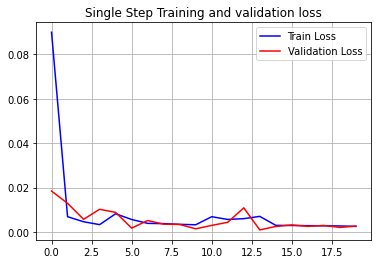

In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

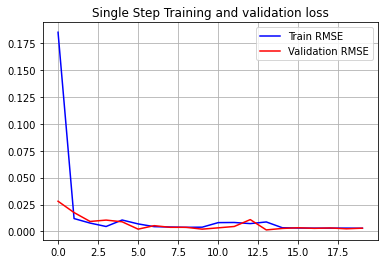

In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['rmse']
  val_loss = history.history['val_rmse']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train RMSE')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation RMSE')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

We defined a function `create_time_steps` to create time steps and function `plot_time_series` to plot the time series data

In [ ]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

In [ ]:
### Moving window average

def MWA(history):
  return np.mean(history)

We plotted the time series and predicted values

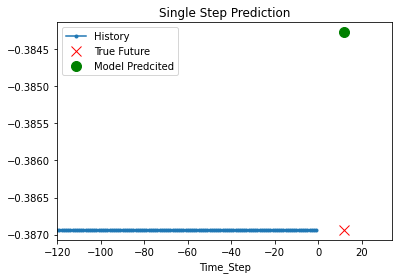

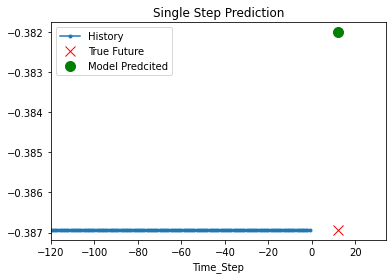

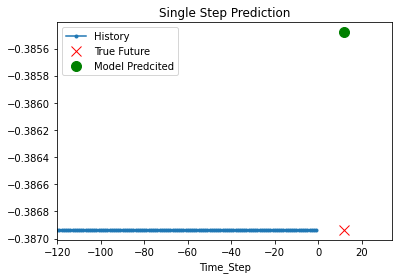

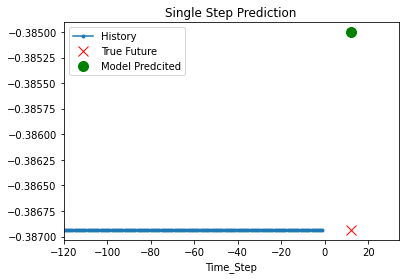

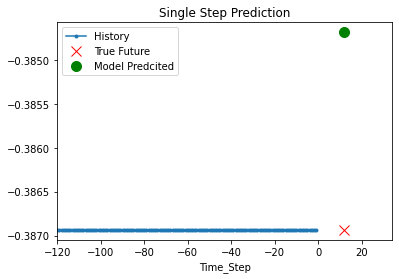

In [ ]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

# **MultiStep Forcasting**

We splitted the data in the form of training and validation for multistep forcasting:

In [ ]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(features, features[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(features, features[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(140880, 120, 7)
(140880, 72)


The `tf.data.Dataset` API supports writing descriptive and efficient input pipelines. Dataset usage following a common pattern:
- Creating a source dataset from our input data.
- Applied dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.
Note: Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.
Once we have a dataset, we can apply transformations to prepare the data for our model:

In [ ]:
#  TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [ ]:
print(train_data_multi)
print(val_data_multi)

<RepeatDataset shapes: ((None, 120, 7), (None, 72)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 120, 7), (None, 72)), types: (tf.float64, tf.float64)>


We created a `multi_step_plot` function to plot between `history` and `true_future` data

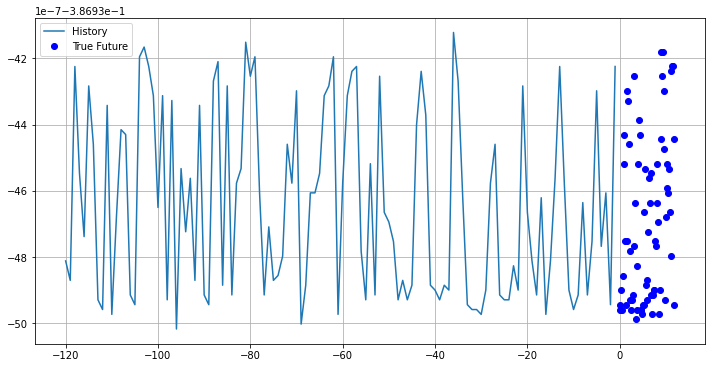

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

We are building a single step LSTM model for training data with dropout 0.3 and we used ADAM optimizers.

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
#aDD dropout layer (0.3)
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae',metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/20
50/50 [==============================] - 14s 226ms/step - loss: 0.2044 - rmse: 0.2723 - val_loss: 0.0922 - val_rmse: 0.1511
Epoch 2/20
50/50 [==============================] - 11s 215ms/step - loss: 0.0574 - rmse: 0.1058 - val_loss: 0.0394 - val_rmse: 0.0519
Epoch 3/20
50/50 [==============================] - 11s 216ms/step - loss: 0.0240 - rmse: 0.0351 - val_loss: 0.0156 - val_rmse: 0.0187
Epoch 4/20
50/50 [==============================] - 11s 214ms/step - loss: 0.0182 - rmse: 0.0226 - val_loss: 0.0054 - val_rmse: 0.0068
Epoch 5/20
50/50 [==============================] - 11s 212ms/step - loss: 0.0164 - rmse: 0.0199 - val_loss: 0.0096 - val_rmse: 0.0110
Epoch 6/20
50/50 [==============================] - 11s 219ms/step - loss: 0.0148 - rmse: 0.0179 - val_loss: 0.0129 - val_rmse: 0.0157
Epoch 7/20
50/50 [==============================] - 11s 217ms/step - loss: 0.0137 - rmse: 0.0163 - val_loss: 0.0071 - val_rmse: 0.0084
Epoch 8/20
50/50 [==============================] - 11s

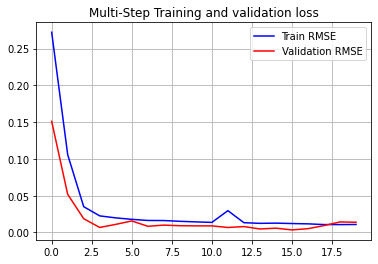

In [ ]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')

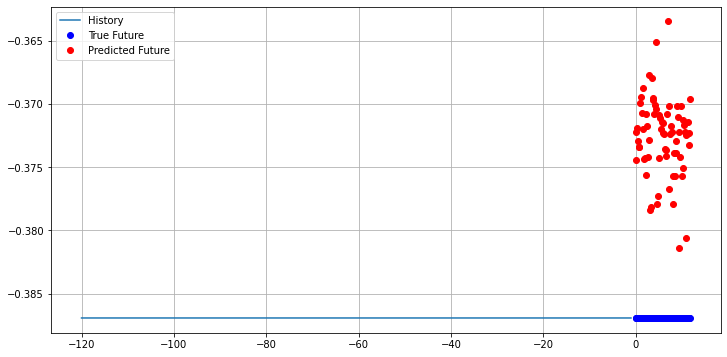

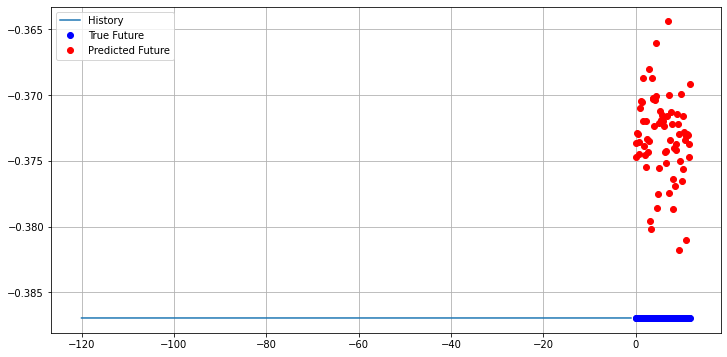

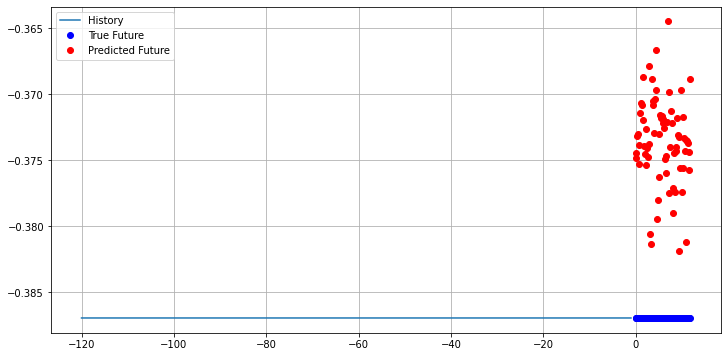

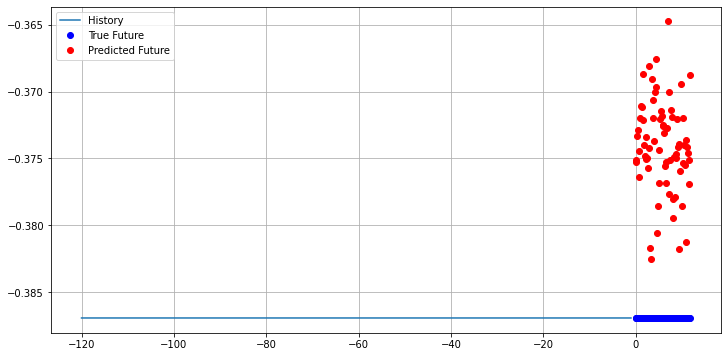

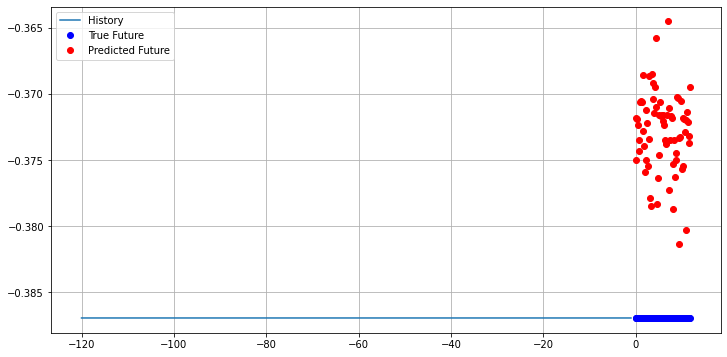

In [ ]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
scores = multi_step_model.evaluate(x_train_multi, y_train_multi, verbose=1, batch_size=200)
print('MAE: {}'.format(scores[1]))

705/705 [==============================] - 36s 51ms/step - loss: 0.0147 - rmse: 0.0161
MAE: 0.016090337187051773


In [ ]:
scores_test = multi_step_model.evaluate(x_val_multi, y_val_multi, verbose=1, batch_size=200)
print('MAE: {}'.format(scores[1]))

174/174 [==============================] - 9s 51ms/step - loss: 0.0142 - rmse: 0.0151
MAE: 0.016090337187051773
